# Chosen DataSet: MovieLens 25M
source: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset

The movie recommendation dataset containing ratings and metadata for movies. Details about what each file found in Data/MovieLens-2M folder contain:

movies.csv: Contains information about the movies in the dataset. Each row represents a movie and includes the following columns:
- movieId: The id for the movie, an integer. Movies are ordered by movieId.
- title: The title of the movie, the year of production is included after the title in (). Example: Toy Story (1995)
- genres: A list of genres associated with the movie, separated by |. Example: Action|Comedy|Drama.

ratings.csv: Contains user ratings for the movies. Each row represents a rating given by a user to a movie and includes the following columns:
- userId: The id for the user, integer (ordered by it).
- movieId: The id of the movie being rated (as in movies.csv).
- rating: The rating given by the user (on a scale from 1 to 5, with 0.5 possible, eg. 4.5).
- timestamp: A timestamp indicating when the rating was given (in Unix format).

tags.csv: Contains user-generated tags for the movies. Each row represents a user-assigned tag to a movie and includes the following columns:
- userId: The id of the user who assigned the tag.
- movieId: The id of the movie to which the tag is assigned.
- tag: The user-generated tag for the movie.
- timestamp: A timestamp indicating when the tag was assigned (in Unix format).

genome-scores.csv: Contains relevance scores that indicate how relevant each tag is to each movie in the dataset.
Each row in the "genome-scores.csv" file represents a pair of a movie and a tag and includes the following columns:
- movieId: The id for the movie.
- tagId: The id for the tag.
- relevance: A number between 0 and 1 indicating the relevance of the tag to the movie. Higher scores indicate higher relevance.

genome-tags.csv: Contains information about the tags used in the dataset, which are associated with movies.
Each row in the "genome-tags.csv" file represents a unique tag and includes the following columns:
- tagId: The id for the tag.
- tag: The textual description of the tag.

The following is not used, as both platforms require API calls to access the data, which has its limits - instead the WikipediaMoviePlots dataset is used:

links.csv: Provides a mapping between MovieLens movie IDs and movie IDs used in IMDb (Internet Movie Database) and TMDb (The Movie Database).
- movieId: The id for the movie within the MovieLens dataset.
- imdbId: The id for the movie within IMDb.
- tmdbId: The id for the movie within TMDb.

In [105]:
import pandas as pd
movie_lens_folder = "./MovieLens-25M"
ratings_df = pd.read_csv(movie_lens_folder + "/ratings.csv")
movies_df = pd.read_csv(movie_lens_folder + "/movies.csv")
display(movies_df.head(10))
display(ratings_df.head(10))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


# 1) Selecting a 100K subset of the dataset
In order to make an informed decision about how to select the subset of the data meaningfully, lets first explore the data and it's statistics:

,Metric,Value
0,Number of Ratings,25000095
1,Number of Unique Users,162541
2,Number of Unique Movies,59047
3,Overall Rating Density [%],0.260484
4,Rating Variance,1.125178
5,Item Coverage,94.591737
6,"Time Span (From, To)","1995-01-09 11:46:49, 2019-11-21 09:15:03"
7,Average Ratings per Day,2752.740049
8,"User Activity (Mean, Min, Max)","153.80793153727367, 20.0, 32202.0"
9,"Movie Popularity (Mean, Min, Max)","423.3931444442563, 1.0, 81491.0"


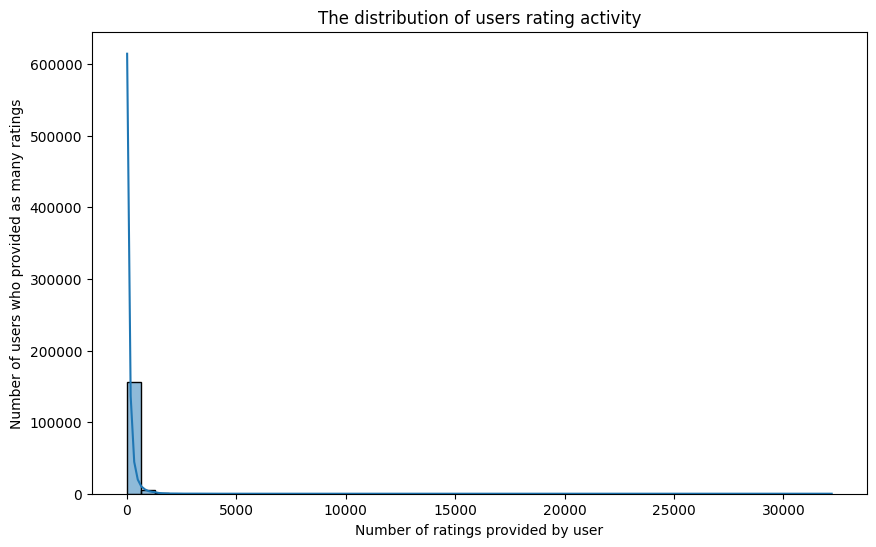

,index,movieId,userId
0,0,356,81491
1,1,318,81482
2,2,296,79672
3,3,593,74127
4,4,2571,72674
...,...,...,...
59042,59042,167308,1
59043,59043,167326,1
59044,59044,167336,1
59045,59045,167338,1


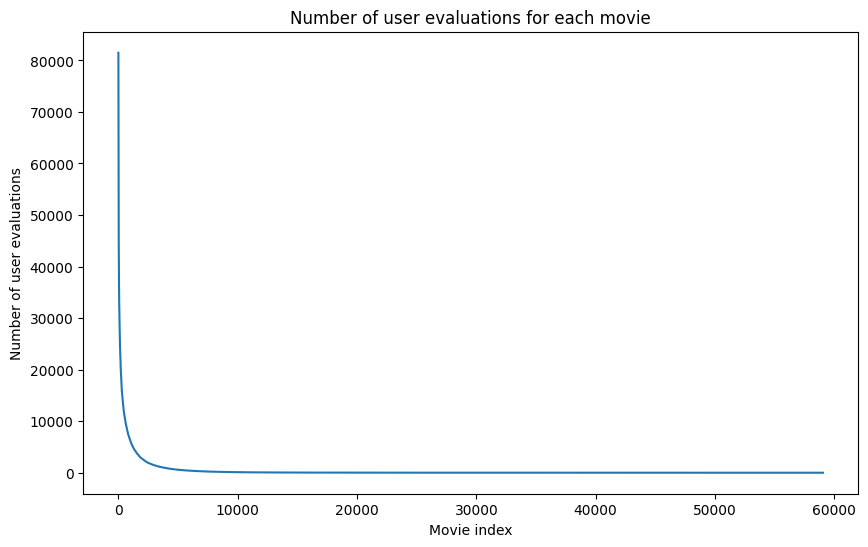

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_data_statistics(ratings_dataframe, movies_dataframe):
    ratings = ratings_dataframe
    movies = movies_dataframe
    num_ratings = len(ratings)
    num_users = ratings['userId'].nunique()
    num_movies = ratings['movieId'].nunique()

    overall_rating_density = 100 * num_ratings / (num_users * num_movies)
    rating_variance = ratings['rating'].var()
    unique_movies_total = movies['movieId'].nunique()
    unique_movies_with_ratings = ratings['movieId'].nunique()
    item_coverage = (unique_movies_with_ratings / unique_movies_total) * 100

    min_timestamp = pd.to_datetime(ratings['timestamp'], unit='s').min()
    max_timestamp = pd.to_datetime(ratings['timestamp'], unit='s').max()
    time_span = max_timestamp - min_timestamp
    avg_ratings_per_day = num_ratings / (time_span.total_seconds() / (60 * 60 * 24))
    user_activity = ratings['userId'].value_counts().describe()
    movie_popularity = ratings['movieId'].value_counts().describe()
    avg_rating_per_movie = ratings.groupby('movieId')['rating'].mean()
    avg_rating_per_movie = avg_rating_per_movie.describe()
    avg_rating_per_user = ratings.groupby('userId')['rating'].mean()
    avg_rating_per_user = avg_rating_per_user.describe()

    statistics = pd.DataFrame({
        'Metric': ['Number of Ratings', 'Number of Unique Users', 'Number of Unique Movies',
                   'Overall Rating Density [%]', 'Rating Variance', 'Item Coverage',
                   'Time Span (From, To)',
                   'Average Ratings per Day',
                   'User Activity (Mean, Min, Max)',
                   'Movie Popularity (Mean, Min, Max)',
                   'Avg. Rating per Movie (Mean, Min, Max)',
                   'Avg. Rating per User (Mean, Min, Max)'],
        'Value': [num_ratings, num_users, num_movies, overall_rating_density, rating_variance,              item_coverage, f'{min_timestamp}, {max_timestamp}', avg_ratings_per_day,
                  f'{user_activity["mean"]}, {user_activity["min"]}, {user_activity["max"]}',
                  f'{movie_popularity["mean"]}, {movie_popularity["min"]}, {movie_popularity["max"]}',
                  f'{avg_rating_per_movie["mean"]:.2f}, {avg_rating_per_movie["min"]:.2f}, {avg_rating_per_movie["max"]:.2f}',
                  f'{avg_rating_per_user["mean"]:.2f}, {avg_rating_per_user["min"]:.2f}, {avg_rating_per_user["max"]:.2f}']
    })

    display(statistics)

    ratings_per_user = ratings['userId'].value_counts().reset_index()
    ratings_per_user.columns = ['userId', 'ratings_count']
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_per_user['ratings_count'], bins=50, kde=True)
    plt.xlabel('Number of ratings provided by user')
    plt.ylabel('Number of users who provided as many ratings')
    plt.title('The distribution of users rating activity')
    plt.show()
    plt.figure(figsize=(10, 6))
    count_ratings_df = ratings[['userId','movieId']].groupby(['movieId']).count()
    count_ratings_df_ord = count_ratings_df.sort_values(by="userId", ascending=False).reset_index().reset_index()
    display(count_ratings_df_ord)
    sns.lineplot(data=count_ratings_df_ord, x='index', y='userId')
    plt.title('Number of user evaluations for each movie')
    plt.xlabel('Movie index')
    plt.ylabel('Number of user evaluations')
    plt.show()

display_data_statistics(ratings_df, movies_df)

As it can be seen, the data is quite sparse (overall rating density of 0.26%). To make group recommendation task easier, lets try to eliminate the sparseness by selecting a less-sparse subset, according to the following steps:
1) Filtering users: selecting users who have rated at least 10*mean_user_activity items. This helps ensure that users have a high level of engagement with the dataset.

2) Filtering items: selecting movies that have received a minimum number of 10*mean_item_popularity ratings. This ensures that items in the subset are relatively popular.

3) Random Sampling: random sampling to select 100,000 ratings from the filtered dataset

'The size of the ratings dataset after user and item filtering: 695731'

Size of the selected subset of ratings: 100000
Size of the selected subset of movies : 1413


,Metric,Value
0,Number of Ratings,100000
1,Number of Unique Users,844
2,Number of Unique Movies,1413
3,Overall Rating Density [%],8.385238
4,Rating Variance,1.037457
5,Item Coverage,100.0
6,"Time Span (From, To)","1997-09-15 21:15:16, 2019-11-20 20:09:09"
7,Average Ratings per Day,12.344225
8,"User Activity (Mean, Min, Max)","118.48341232227489, 19.0, 209.0"
9,"Movie Popularity (Mean, Min, Max)","70.77140835102618, 17.0, 141.0"


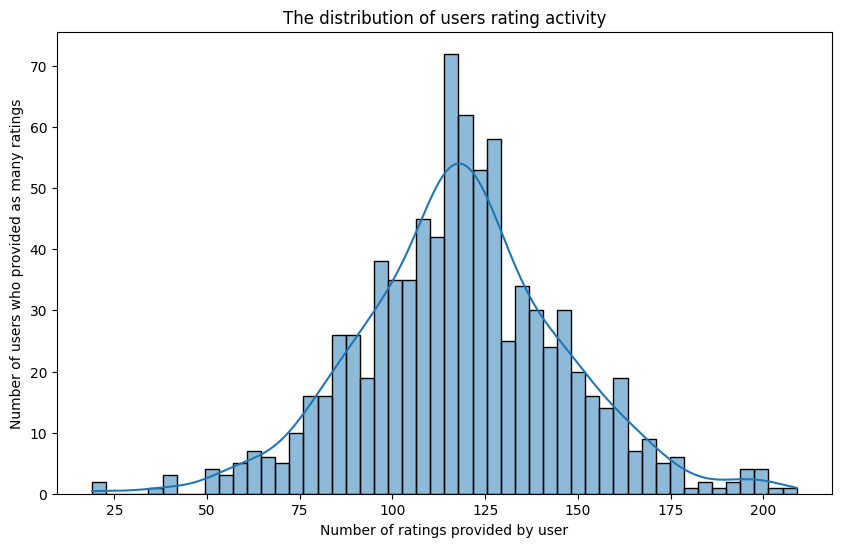

,index,movieId,userId
0,0,1265,141
1,1,480,136
2,2,2571,133
3,3,47,130
4,4,924,126
...,...,...,...
1408,1408,207,23
1409,1409,140,23
1410,1410,276,23
1411,1411,41,20


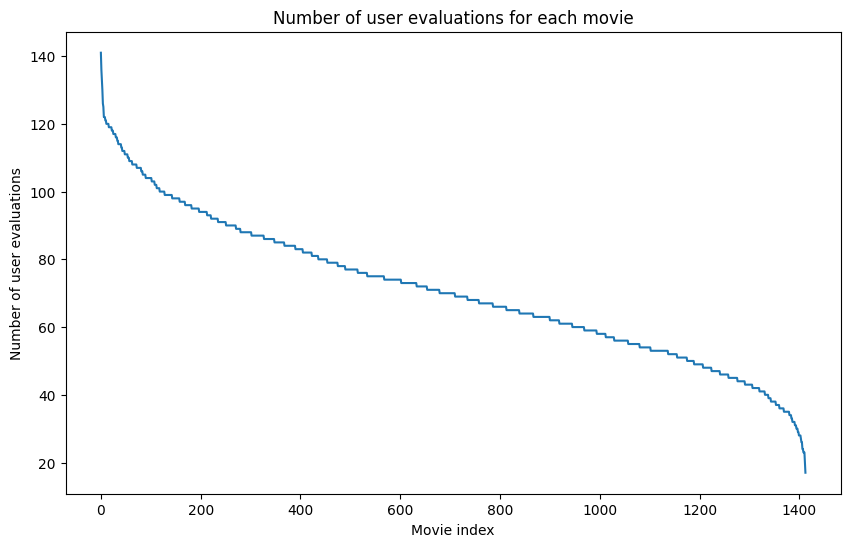

In [107]:
subset_size = 100000
mean_user_activity = 153.80793153727367 
mean_movie_popularity = 423.3931444442563
min_user_ratings = int(10*mean_user_activity)
min_item_ratings = int(10*mean_movie_popularity)

user_ratings_count = ratings_df['userId'].value_counts()
valid_users = user_ratings_count[user_ratings_count >= min_user_ratings].index.tolist() # get the ids of users who have more than minimum number of ratings

item_ratings_count = ratings_df['movieId'].value_counts()
valid_items = item_ratings_count[item_ratings_count >= min_item_ratings].index.tolist()

movies_subset = movies_df[movies_df['movieId'].isin(valid_items)]
filtered_ratings = ratings_df[(ratings_df['userId'].isin(valid_users)) & (ratings_df['movieId'].isin(valid_items))]
display(f'The size of the ratings dataset after user and item filtering: {len(filtered_ratings)}')
selected_ratings = filtered_ratings.sample(n=subset_size, random_state=42)
ratings_subset = pd.DataFrame(selected_ratings)
print("Size of the selected subset of ratings:", len(ratings_subset))
print("Size of the selected subset of movies :", len(movies_subset))
display_data_statistics(selected_ratings, movies_subset)

As we can see, with this preprocessing steps we were able to filter a 100K subset of MovieLens 25M that has a higher density (8.4%) than the MovieLens 100K dataset (6.3%) (movielens-small) which is described in Harper, et al. (2015) "The MovieLens Datasets: History and Context". Also, we got rid of the "long tail" distribution! Now the first graph resembles the Gaussian distribution! This is a very satisfactory result, thus after some final following preprocessing steps we can save it and use it for our recommenders.

Let's rename the columns of the dataset such that they match LensKit requirements. Also split the title and year into two different columns, and remove duplicates.

In [108]:
def compute_title_year(row):
    title_original = str(row['title_original']).strip()
    year = title_original[-5:-1]
    if year.isdigit():
        title = title_original[:-6].strip().lower()
        return int(year), title
    else:
        return 0, title_original.lower()

ratings_subset = ratings_subset.rename(columns={'userId': 'user', 'movieId': 'item'})
movies_subset = movies_subset.rename(columns={'movieId': 'item', 'title' : 'title_original'})
movies_subset[['year', 'title']] = movies_subset.apply(compute_title_year, axis=1, result_type ='expand')
movies_subset = movies_subset.drop_duplicates(subset='title', keep='first')

display(ratings_subset.head(10))
display(movies_subset.head(10))

,user,item,rating,timestamp
2678222,17783,5954,5.0,1288572640
22672930,147353,2805,2.0,979368264
2114504,14139,318,5.0,957887739
24950393,162271,2019,3.5,1148505475
5038954,32778,1982,4.0,1559214270
2576462,17160,1225,4.5,1151466878
8901834,58005,6537,3.0,1112739432
20461544,133040,736,2.0,1076959711
11352344,73670,4975,2.0,1415292692
18225819,118041,1248,4.5,1522631138


,item,title_original,genres,year,title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,toy story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,grumpier old men
4,5,Father of the Bride Part II (1995),Comedy,1995,father of the bride part ii
5,6,Heat (1995),Action|Crime|Thriller,1995,heat
6,7,Sabrina (1995),Comedy|Romance,1995,sabrina
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,goldeneye
10,11,"American President, The (1995)",Comedy|Drama|Romance,1995,"american president, the"
13,14,Nixon (1995),Drama,1995,nixon
15,16,Casino (1995),Crime|Drama,1995,casino


# 2) Merging with Dataset with Movie Metadata - Wikipedia Movie Plots
source: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

The dataset contains metadata about movies. It has the following columns:

- release Year: the year in which the movie was released (first premiere).

- title: the titles of the movie.

- origin/ethnicity: the country or cultural background from which the movie originates.

- director: the names of the individuals who directed the movies.

- cast: the names of the actors and actresses who appear in the movie.

- genre: the category or type of the movie.

- wiki Page: contains links to the Wikipedia pages associated with each movie.

- plot: the plot summaries or descriptions of the movies.

In [109]:
wiki_plots_dataset_folder = "./WikipediaMoviePlots"
plots_df = pd.read_csv(wiki_plots_dataset_folder+"/wiki_movie_plots_deduped.csv")
plots_df['title'] = plots_df['Title'].str.strip().str.lower() 
plots_df['cast'] = plots_df['Cast'].str.strip().str.lower()
plots_df['director'] = plots_df['Director'].str.strip().str.lower()
plots_df['origin'] = plots_df['Origin/Ethnicity'].str.strip().str.lower()
plots_df = plots_df.rename(columns={'Release Year': 'year', 'Plot' : 'plot'})
plots_df = plots_df[['title', 'year', 'cast', 'director', 'origin','plot']]
plots_df = plots_df.drop_duplicates(subset=['title','year'], keep='first')
display(plots_df.head(10))

,title,year,cast,director,origin,plot
0,kansas saloon smashers,1901,NaN,unknown,american,"A bartender is working at a saloon, serving dr..."
1,love by the light of the moon,1901,NaN,unknown,american,"The moon, painted with a smiling face hangs ov..."
2,the martyred presidents,1901,NaN,unknown,american,"The film, just over a minute long, is composed..."
3,"terrible teddy, the grizzly king",1901,NaN,unknown,american,Lasting just 61 seconds and consisting of two ...
4,jack and the beanstalk,1902,NaN,"george s. fleming, edwin s. porter",american,The earliest known adaptation of the classic f...
5,alice in wonderland,1903,may clark,cecil hepworth,american,"Alice follows a large white rabbit down a ""Rab..."
6,the great train robbery,1903,NaN,edwin s. porter,american,The film opens with two bandits breaking into ...
7,the suburbanite,1904,NaN,wallace mccutcheon,american,The film is about a family who move to the sub...
8,the little train robbery,1905,NaN,edwin stanton porter,american,The opening scene shows the interior of the ro...
9,the night before christmas,1905,NaN,edwin stanton porter,american,Scenes are introduced using lines of the poem....


In [110]:
movies_subset_merged = pd.merge(movies_subset, plots_df,  how='inner', left_on=['title','year'], right_on = ['title','year'])
movies_subset_merged = movies_subset_merged[['item','title_original','genres', 'year','title', 'cast', 'director', 'origin', 'plot']]
display(movies_subset_merged.head(10))
print("Number of movies: " + str(movies_subset_merged.shape[0]))
ratings_subset_merged = ratings_subset.loc[ratings_subset['item'].isin(movies_subset_merged['item'])]
print("Number of ratings after final filtering: " + str(ratings_subset_merged.shape[0]))

,item,title_original,genres,year,title,cast,director,origin,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,toy story,"tim allen, tom hanks (voices)",john lasseter,american,In a world where toys are living things who pr...
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,jumanji,"robin williams, bonnie hunt, kirsten dunst, br...",joe johnston,american,"In 1869, near Brantford, New Hampshire, two br..."
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,grumpier old men,"jack lemmon, walter matthau, ann-margret, soph...",howard deutch,american,The feud between Max (Walter Matthau) and John...
3,5,Father of the Bride Part II (1995),Comedy,1995,father of the bride part ii,"steve martin, diane keaton, martin short, kimb...",charles shyer,american,The film begins five years after the events of...
4,6,Heat (1995),Action|Crime|Thriller,1995,heat,"al pacino, robert de niro, val kilmer, ashley ...",michael mann,american,"Neil McCauley, a career criminal, hires Waingr..."
5,7,Sabrina (1995),Comedy|Romance,1995,sabrina,"harrison ford, julia ormond, greg kinnear, nan...",sydney pollack,american,Sabrina Fairchild is the young daughter of the...
6,10,GoldenEye (1995),Action|Adventure|Thriller,1995,goldeneye,"pierce brosnan, sean bean, famke janssen",martin campbell,british,"In 1986, at Arkhangelsk, MI6 agents James Bond..."
7,14,Nixon (1995),Drama,1995,nixon,"anthony hopkins, joan allen, james woods, j. t...",oliver stone,american,The movie begins in 1972 with the White House ...
8,16,Casino (1995),Crime|Drama,1995,casino,"robert de niro, sharon stone, joe pesci, james...",martin scorsese,american,"In 1973, sports handicapper and Mafia associat..."
9,17,Sense and Sensibility (1995),Drama|Romance,1995,sense and sensibility,"emma thompson, alan rickman, kate winslet, hug...",ang lee,american,"On his deathbed, Mr. Dashwood tells his son fr..."


Number of movies: 978
Number of ratings after final filtering: 69742


In the end, we have narrowed our subset of users and movies even more, to choose only the movies that have metadata. Let's check once again how do the data statistics look now:

,Metric,Value
0,Number of Ratings,69742
1,Number of Unique Users,844
2,Number of Unique Movies,978
3,Overall Rating Density [%],8.449151
4,Rating Variance,1.037218
5,Item Coverage,100.0
6,"Time Span (From, To)","1997-09-15 21:15:16, 2019-11-20 20:09:02"
7,Average Ratings per Day,8.609109
8,"User Activity (Mean, Min, Max)","82.63270142180095, 15.0, 148.0"
9,"Movie Popularity (Mean, Min, Max)","71.31083844580778, 20.0, 141.0"


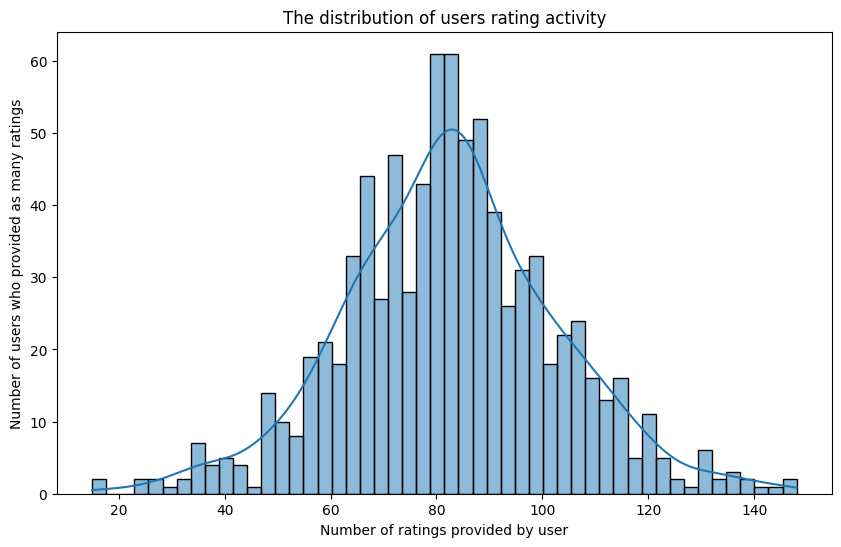

,index,movieId,userId
0,0,1265,141
1,1,480,136
2,2,924,126
3,3,1721,122
4,4,527,121
...,...,...,...
973,973,237,26
974,974,222,24
975,975,69,24
976,976,276,23


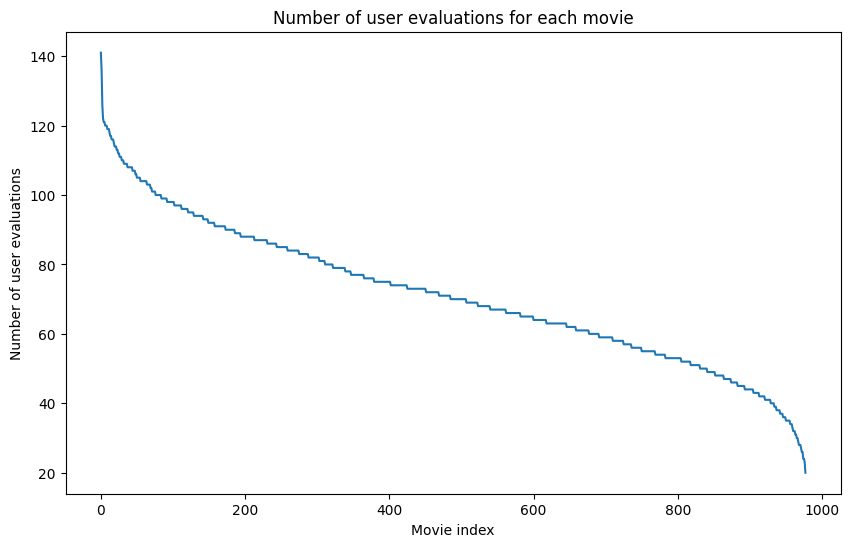

In [111]:
ratings_check = ratings_subset_merged.rename(columns={'user': 'userId', 'item': 'movieId'})
movies_check = movies_subset_merged.rename(columns={'item': 'movieId'})
display_data_statistics(ratings_check, movies_check)

The rating density is still high, as well as item coverage, hence we will keep this filtered dataset as our final subset. Let's save it:

In [114]:
preprocessed_dataset_folder = "./PreprocessedDataset"
ratings_subset_merged.to_csv(preprocessed_dataset_folder+"/ratings.csv", index=False)
movies_subset_merged.to_csv(preprocessed_dataset_folder+"/movies.csv", index=False)